#### [ 로지스틱, KNN기반 분류 모델 - 생존자 분류 ]
- 데이터셋 : titanic.csv
- 주제 : 생존자분류
- 타겟 : Survived
- 피쳐 : 상관관계 높은 피쳐.
- 학습종류 : 지도학습 /분류
- 알고리즘 : 로지스틱, KNN 기반 분류진행

In [1]:
## 1-1
import pandas as pd
# 데이터 분석 및 전처리
import numpy as np
# 숫자처리
import matplotlib.pyplot as plt
# 데이터 시각화
from sklearn.neighbors import KNeighborsRegressor
                                #knn
from sklearn.linear_model import LinearRegression, LogisticRegression
                            ## ML 알고리즘
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
                            ## 성능평가 모듈
from sklearn.model_selection import train_test_split
                            ## 데이터셋 분리 관련 모듈
                            ## 학습/검증/테스트 
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
                            ## 정규화, 컬럼추가

from _utils import tools as ts                             

#### [1] 데이터 준비 및 확인

PassengerId	승객의 고유 ID<br>
Survived	생존 여부 (0 = 사망, 1 = 생존)<br>
Pclass	티켓 등급 (1 = 1등석, 2 = 2등석, 3 = 3등석)<br>
Name	승객의 이름<br>
Sex	성별 (male, female)<br>
Age	나이 (일부 결측값 존재)<br>
SibSp	함께 탑승한 형제자매 및 배우자의 수<br>
Parch	함께 탑승한 부모 및 자녀의 수<br>
Ticket	티켓 번호<br>
Fare	운임 요금<br>
Cabin	선실 번호 (일부 결측값 존재)<br>
Embarked 탑승한 항구

In [2]:
originDF = pd.DataFrame(pd.read_csv('../data/train.csv', index_col='PassengerId'))
originDF.info()
originDF.head()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


데이터 분석
- Name은 변별력이 없음. 
- Ticket과 Pclass간 관계, 같은 티켓을 사용한 사용자간 관계 추측.
- Cabin -> 결측값 다수. 티켓 및 fare로 추측하기.

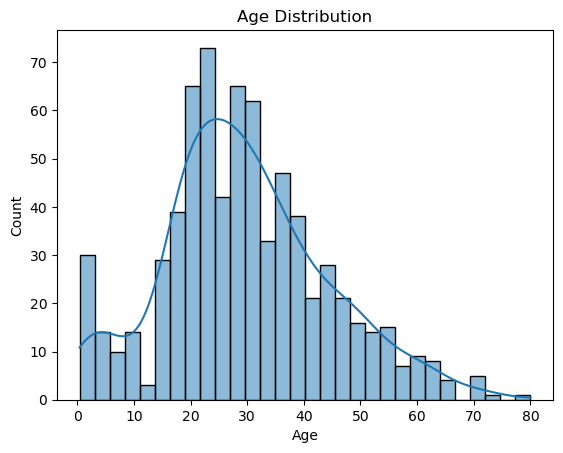

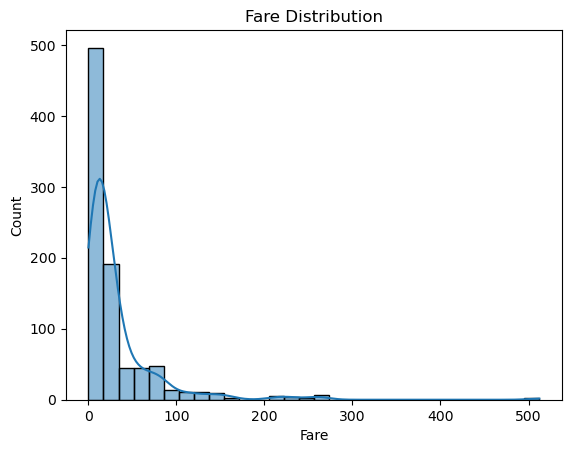

In [3]:
import seaborn as sns

# Age 분포 확인
sns.histplot(originDF['Age'], kde=True, bins=30)
plt.title("Age Distribution")
plt.show()

# Fare 분포 확인
sns.histplot(originDF['Fare'], kde=True, bins=30)
plt.title("Fare Distribution")
plt.show()


In [4]:
originDF = originDF.drop(index=originDF[originDF['Fare']>300].index)

In [5]:
originDF.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       686
Embarked      2
dtype: int64

In [6]:
titles = [
    "Mr.", "Mrs.", "Miss.", "Master.", "Dr.", 
    "Rev.", "Col.", "Major.", "Sir.", "Lady.", 
    "Countess.", "Ms.", "Mlle.", "Mme.", "Dr. Mrs."
]
for i in titles:
    if originDF[(originDF['Name'].str.contains(i) & (originDF['Age'].isna()))].index.any():
        a = originDF[(originDF['Name'].str.contains(i))]['Age'].mean()
        nullindex = originDF[(originDF['Name'].str.contains(i)) & (originDF['Age'].isna())]['Age'].index
        print(i, a, len(nullindex))
        originDF.loc[nullindex,'Age'] = originDF.loc[nullindex,'Age'].fillna(a)

Mr. 33.1090373280943 136
Miss. 21.682758620689654 36
Master. 4.574166666666667 4
Dr. 37.85363984674329 1


In [7]:
originDF.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       686
Embarked      2
dtype: int64

In [8]:
newDF = originDF.drop(columns=['Name','SibSp', 'Parch', 'Ticket', 'Embarked'])
newDF

,Survived,Pclass,Sex,Age,Fare,Cabin
PassengerId,,,,,,
1,0,3,male,22.000000,7.2500,NaN
2,1,1,female,38.000000,71.2833,C85
3,1,3,female,26.000000,7.9250,NaN
4,1,1,female,35.000000,53.1000,C123
5,0,3,male,35.000000,8.0500,NaN
...,...,...,...,...,...,...
887,0,2,male,27.000000,13.0000,NaN
888,1,1,female,19.000000,30.0000,B42
889,0,3,female,21.682759,23.4500,NaN


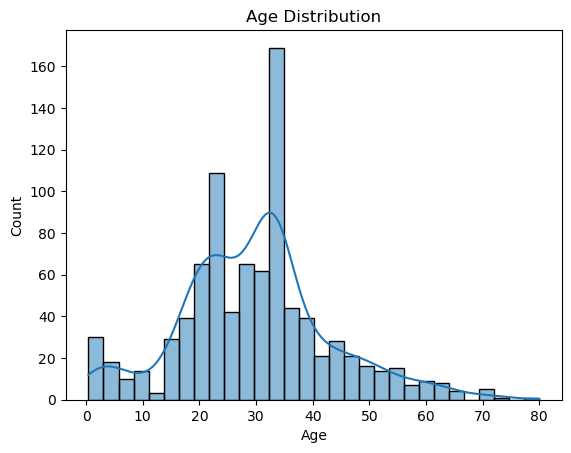

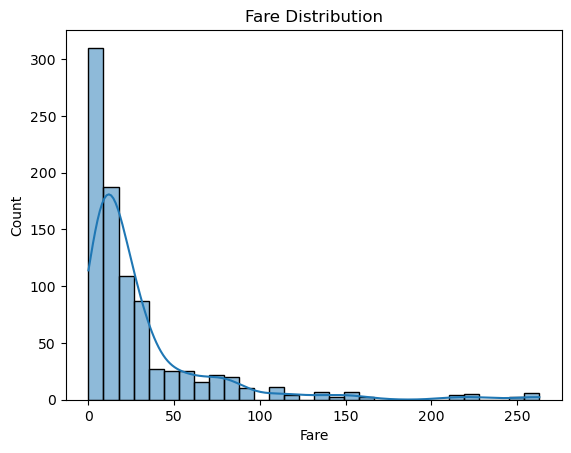

In [9]:
import seaborn as sns

# Age 분포 확인
sns.histplot(newDF['Age'], kde=True, bins=30)
plt.title("Age Distribution")
plt.show()

# Fare 분포 확인
sns.histplot(newDF['Fare'], kde=True, bins=30)
plt.title("Fare Distribution")
plt.show()


In [10]:
originDF[originDF['Age'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


Cabin 컬럼은 빈값이 너무 많아 채우더라도 진실성이 의심됨. 폐기
label 필요 컬럼
Sex, Age, Fare, Embarked

In [11]:
# originDF.to_csv('titanic_prepro.csv', encoding='utf-8')

In [12]:
originDF.drop(columns='Cabin',inplace=True)

In [13]:
## male = 0 , female = 1
originDF['Sex'] = originDF['Sex'].map({'male': 1, 'female':0})
originDF['Sex'] = originDF['Sex'].astype('int')
originDF['Sex'].value_counts()

Sex
1    575
0    313
Name: count, dtype: int64

In [14]:
newDF = originDF.drop(columns=['Name','SibSp', 'Parch', 'Ticket', 'Embarked'])
newDF

,Survived,Pclass,Sex,Age,Fare
PassengerId,,,,,
1,0,3,1,22.000000,7.2500
2,1,1,0,38.000000,71.2833
3,1,3,0,26.000000,7.9250
4,1,1,0,35.000000,53.1000
5,0,3,1,35.000000,8.0500
...,...,...,...,...,...
887,0,2,1,27.000000,13.0000
888,1,1,0,19.000000,30.0000
889,0,3,0,21.682759,23.4500


In [15]:
newDF['Fare'].max()

263.0

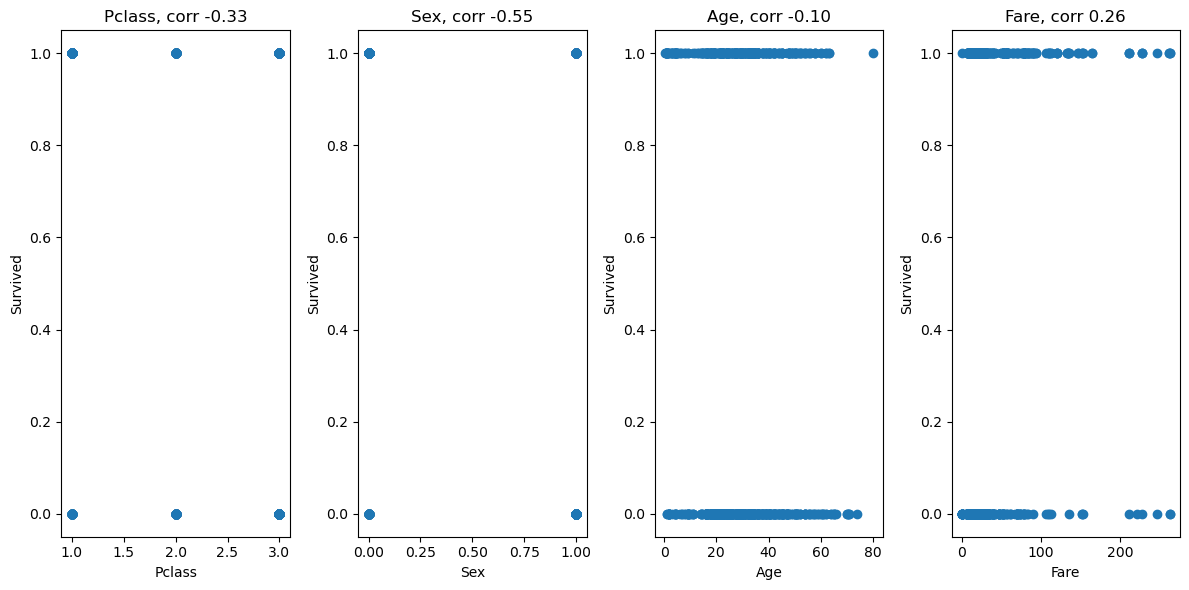

In [16]:
ts.plot_corr(newDF, newDF.columns[[1,2,3,4]], newDF.columns[0])

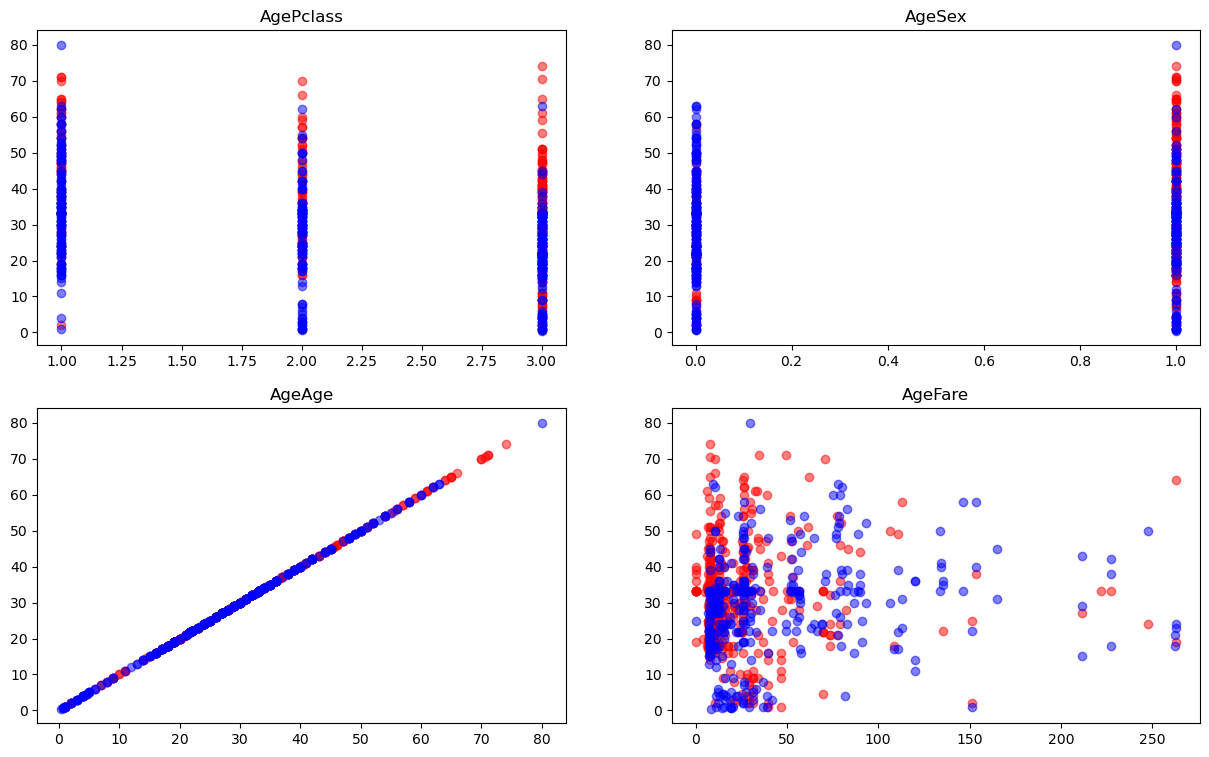

In [17]:
# [1, 3, 4, 5, 6, 8, 12]
fig, axe = plt.subplots(2,2, figsize=(15,9))
axe = axe.flatten()
target = 'Age'
colnum = [1, 2, 3, 4]

dead = newDF[newDF['Survived']==0]
live  = newDF[newDF['Survived']==1]
# print(newDF.columns[colnum])
# print(dead[target])
for ax, i in zip(axe,newDF.columns[colnum]):
    ax.plot(dead[i], dead[target], 'or', alpha=0.5)
    ax.plot(live[i], live[target], 'ob', alpha=0.5)
    ax.set_title(target+i)

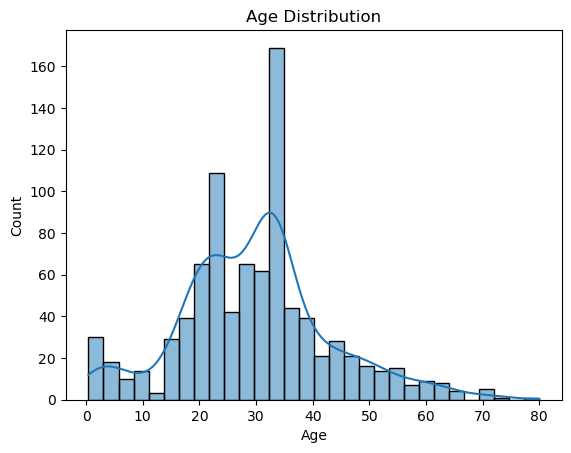

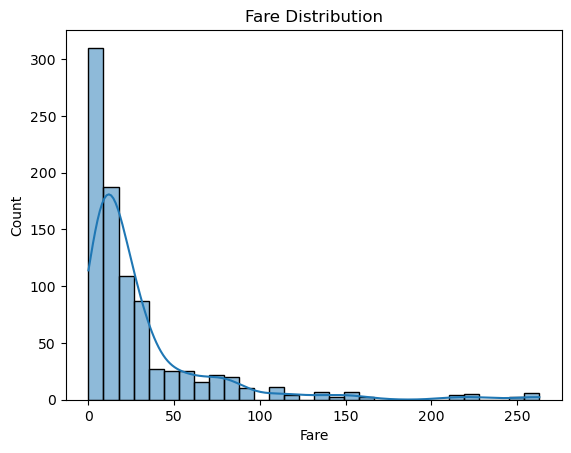

In [18]:
import seaborn as sns

# Age 분포 확인
sns.histplot(newDF['Age'], kde=True, bins=30)
plt.title("Age Distribution")
plt.show()

# Fare 분포 확인
sns.histplot(newDF['Fare'], kde=True, bins=30)
plt.title("Fare Distribution")
plt.show()


In [19]:
newDF.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
dtype: int64

In [20]:
featureDF = newDF[newDF.columns[[1,2,3,4]]]
classDF = newDF['Survived']
print(f'featureDF : {featureDF.shape}  classDF : {classDF.shape}')

featureDF : (888, 4)  classDF : (888,)


In [21]:
## - 회귀가 아니고 분류 시행시에는
## 훈련용이랑 테스트용에 동일한 비율로 
## 타겟이 배분되어야 한다.
## setosa : versi = 5:5
#  ==> stratify 매개변수: 타겟 데이터셋의 클래스/라벨 비율에 맞게 학습용/테스트용 분리.
# pytorch엔 없음.

train_X, test_X, train_y, test_y = train_test_split(featureDF, classDF,
                                                    random_state=7,
                                                    test_size=0.2,
                                                    stratify=classDF)
print(f"train_X => {train_X.ndim}D {train_X.shape} / test_X => {test_X.ndim}D, {test_X.shape}")
print(f"train_y => {train_y.ndim}D {train_y.shape}, / test_y => {test_y.ndim}D, {test_y.shape}")
    

train_X => 2D (710, 4) / test_X => 2D, (178, 4)
train_y => 1D (710,), / test_y => 1D, (178,)


#### [3] 학습 
- 메인학습 : 지도학습 - 분류
- 세부학습 : 선형모델 로지스틱회귀

In [22]:
# 학습 진행 ==> 훈련용 데이터 진행 fit(2D, 1D)
logR=LogisticRegression()
logR.fit(train_X, train_y)

LogisticRegression()

In [23]:
# 분류모델 성능 체크 ==> 정확도 accuracy 가 성능체크로 사용됨
#train_X, test_X, train_y, test_y

score_test1 = logR.score(test_X, test_y)
score_test2 = logR.score(train_X, train_y)
score_test2, score_test1

(0.8098591549295775, 0.7640449438202247)

In [24]:
train_X.head()

,Pclass,Sex,Age,Fare
PassengerId,,,,
518,3,1,33.109037,24.1500
90,3,1,24.000000,8.0500
46,3,1,33.109037,8.0500
126,3,1,12.000000,11.2417
138,1,1,37.000000,53.1000


In [25]:
## 각 컬럼 정규화.

In [26]:
featureDF = newDF[newDF.columns[[1,2,3,4]]]
classDF = newDF['Survived']
print(f'featureDF : {featureDF.shape}  classDF : {classDF.shape}')

train_X, test_X, train_y, test_y = train_test_split(featureDF, classDF,
                                                    random_state=7,
                                                    test_size=0.2,
                                                    stratify=classDF)
print(f"train_X => {train_X.ndim}D {train_X.shape} / test_X => {test_X.ndim}D, {test_X.shape}")
print(f"train_y => {train_y.ndim}D {train_y.shape}, / test_y => {test_y.ndim}D, {test_y.shape}")
    

featureDF : (888, 4)  classDF : (888,)
train_X => 2D (710, 4) / test_X => 2D, (178, 4)
train_y => 1D (710,), / test_y => 1D, (178,)


In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
sScaler = StandardScaler()
sScaler.fit(train_X[['Age']])
train_X['Age'] = sScaler.transform(train_X[['Age']])

rScaler = RobustScaler()
rScaler.fit(train_X[['Fare']])
train_X['Fare'] = rScaler.transform(train_X[['Fare']])


In [28]:
train_X.head()

,Pclass,Sex,Age,Fare
PassengerId,,,,
518,3,1,0.254191,0.396694
90,3,1,-0.426891,-0.265148
46,3,1,0.254191,-0.265148
126,3,1,-1.324130,-0.133943
138,1,1,0.545118,1.586775


In [29]:
logR=LogisticRegression()
logR.fit(train_X, train_y)

score_test1 = logR.score(test_X, test_y)
score_test2 = logR.score(train_X, train_y)
score_test2, score_test1

(0.8098591549295775, 0.6179775280898876)

[6] 성능지표 평가<hr>


In [30]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report, f1_score


In [31]:
## 예측값 계산
pre_y = logR.predict(test_X)
precision = precision_score(test_y, pre_y)
recall = recall_score(test_y,pre_y)
f1 = f1_score(test_y,pre_y)

print(precision, recall, f1)

0.0 0.0 0.0


c:\Users\kdt\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
## 분류성능평가 보고서
print(classification_report(test_y, pre_y))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76       110
           1       0.00      0.00      0.00        68

    accuracy                           0.62       178
   macro avg       0.31      0.50      0.38       178
weighted avg       0.38      0.62      0.47       178



c:\Users\kdt\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kdt\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kdt\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
confusion_matrix(test_y,pre_y)

array([[110,   0],
       [ 68,   0]])

[7] 예측 및 시각화 <hr>

In [34]:
train_X

,Pclass,Sex,Age,Fare
PassengerId,,,,
518,3,1,0.254191,0.396694
90,3,1,-0.426891,-0.265148
46,3,1,0.254191,-0.265148
126,3,1,-1.324130,-0.133943
138,1,1,0.545118,1.586775
...,...,...,...,...
610,1,0,0.769428,5.712492
447,2,0,-1.249360,0.205541
851,3,1,-1.922290,0.689589


In [35]:
from sklearn.metrics import log_loss
np.set_printoptions(precision=10, suppress=True)
y_pred=logR.predict(test_X)


In [36]:
len(y_pred), len(test_y)

(178, 178)

In [37]:
# numpy에서의 DataFrame의 replace()와 동일 기능 변경 
# y = 1일 때 오차, y=0일 때 오차계산 ==> 손실/비용계산
test_y_ = np.where(test_y, 1, 0)
y_pred_ = np.where(y_pred, 1, 0)  

loss = log_loss(test_y, y_pred_)
# print(test_y_, y_pred_)
print(f'loss : {loss :.6f}')

loss : 13.769486


In [38]:
### 교차검증

In [39]:
from sklearn.model_selection import cross_validate

In [40]:
result= cross_validate(logR, train_X, train_y)
for key, value in result.items(): print(key, value)

fit_time [0.0041389465 0.00436759   0.0061099529 0.0035431385 0.0056760311]
score_time [0.0030622482 0.0020656586 0.0010735989 0.0025963783 0.0014193058]
test_score [0.7535211268 0.838028169  0.8098591549 0.7957746479 0.7887323944]


In [41]:
result2= cross_validate(logR, train_X, train_y, 
                        return_estimator=True, 
                        return_train_score=True)

In [42]:
for key, value in result2.items(): print(key, value)

fit_time [0.0040152073 0.0032322407 0.           0.           0.0158982277]
score_time [0.0016899109 0.           0.           0.           0.          ]
estimator [LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()]
test_score [0.7535211268 0.838028169  0.8098591549 0.7957746479 0.7887323944]
train_score [0.8186619718 0.8063380282 0.8116197183 0.8151408451 0.8133802817]


In [43]:
# test_score와 train_score 값 비교해서 과대적합/과적합/오버피팅이 되지 않은
# 가장 좋음 모델 선택 후 추출
best_estimator=result2['estimator'][2]

In [44]:
featureDF.head()

,Pclass,Sex,Age,Fare
PassengerId,,,,
1,3,1,22.0,7.2500
2,1,0,38.0,71.2833
3,3,0,26.0,7.9250
4,1,0,35.0,53.1000
5,3,1,35.0,8.0500


In [45]:
classDF.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In [46]:
new_data = pd.DataFrame([[3,1,-0.584902,-0.314923]], columns=featureDF.columns)


In [47]:
best_estimator.predict(new_data)

array([0])

In [48]:
best_estimator.predict_proba(new_data)
# 0일 확률//1일 확률

array([[0.8908345981, 0.1091654019]])

결과 
- 정규화 전 score
    - (0.7845070422535211, 0.6797752808988764)

- 정규화 후 score
    - (0.8676056338028169, 0.7696629213483146)
